To Build Paths:

1. Rename 'filename' variable to include all the names of the dxf files to include in path
2. Run all cells in the nodebook
3. Click on the nodes to connect in order
4. Press 'z' to delete the last drawn path and 'c' to reset the cursor
5. Press 'enter' to export the path connections to a csv file (exports for one way only)

In [1]:
import os.path
from os import path
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ipympl
import csv

In [2]:
def openDXF(filename):
    p = filename + ".dxf"
    if os.path.exists(p):
        with open(p) as f:
            lines = f.read().splitlines()
        return lines
    else:
        return False

def isolateVertex(dxf_list):
    start, end = 0, -1
    flag = False
    for i, c in enumerate(dxf_list):
        if c == "VERTEX" and flag is False:
            start = i
            flag = True
        if c == "ENDSEC":
            end = i+1
        if end > start and flag is True:
            return dxf_list[start:end]
    return None

In [3]:
class treeNode:
    def __init__(self, value, index):
        self.id = index
        self.value = value
        self.right = None
        self.left = None
        self.height = 1

class nodesAVL:
    
    def insert(self, root, value, index):
        if not root:
            return treeNode(value, index)
        elif value < root.value:
            root.left = self.insert(root.left, value, index)
        else:
            root.right = self.insert(root.right, value, index)
    
        root.height = max(self.heightAVL(root.left), self.heightAVL(root.right)) + 1
 
        balanceFactor = self.balanceFactor(root)
        if balanceFactor > 1:
            if value < root.left.value:
                return self.rotateRight(root)
            else:
                root.left = self.rotateLeft(root.left)
                return self.rotateRight(root)
 
        if balanceFactor < -1:
            if value > root.right.value:
                return self.rotateLeft(root)
            else:
                root.right = self.rotateRight(root.right)
                return self.rotateLeft(root)
 
        return root
    
    def rotateLeft(self, b):
        a = b.right
        temp = a.left
        a.left = b
        b.right = temp
        b.height = max(self.heightAVL(b.left), self.heightAVL(b.right)) + 1
        a.height = max(self.heightAVL(a.left), self.heightAVL(a.right)) + 1
        return a
    
    def rotateRight(self, b):
        a = b.left
        temp = a.right
        a.right = b
        b.left = temp
        b.height = max(self.heightAVL(b.left), self.heightAVL(b.right)) + 1
        a.height = max(self.heightAVL(a.left), self.heightAVL(b.right)) + 1
        return a
    
    def heightAVL(self, root):
        if not root:
            return 0
        else:
            return root.height
    
    def balanceFactor(self, root):
        if not root:
            return 0
        else:
            return (self.heightAVL(root.left) - self.heightAVL(root.right))
    
    def minValue(self, root):
        if root is None or root.left is None:
            return root
        else:
            return self.MinValue(root.left)
    
    def find(self, root, value):
        if not root:
            return None
        elif value < root.value:
            return self.find(root.left, value)
        elif value > root.value:
            return self.find(root.right, value)
        elif value == root.value:
            return root.id
        else:
            return None
        
    def preOrder(self, root):
        if not root:
            return 0
        print("{0} ".format(root.value), end=" ")
        self.preOrder(root.left)
        self.preOrder(root.right)
        

In [4]:
filenames = ["road_for_year_123", "ways_for_dumps"]
l2 = []

for s in filenames:
    temp = openDXF(s)
    if temp != False:
        l1 = isolateVertex(temp)
        l2.extend(l1)
        
nodes = nodesAVL()
root = None
count_index = 0
plot = []

for i, c in enumerate(l2):
    if c == "VERTEX" and i<(len(l2)-10):
        t1, t2, t3 = float(l2[i+6]), float(l2[i+8]), float(l2[i+10])
        m = pow(t1, 2) + pow(t2, 2) + pow(t3, 2)
        root = nodes.insert(root, m, count_index)
        count_index = count_index + 1
        plot.append([t1, t2, t3])
        
#g = nodes.find(root, 58955581582025.44)
#print(g)

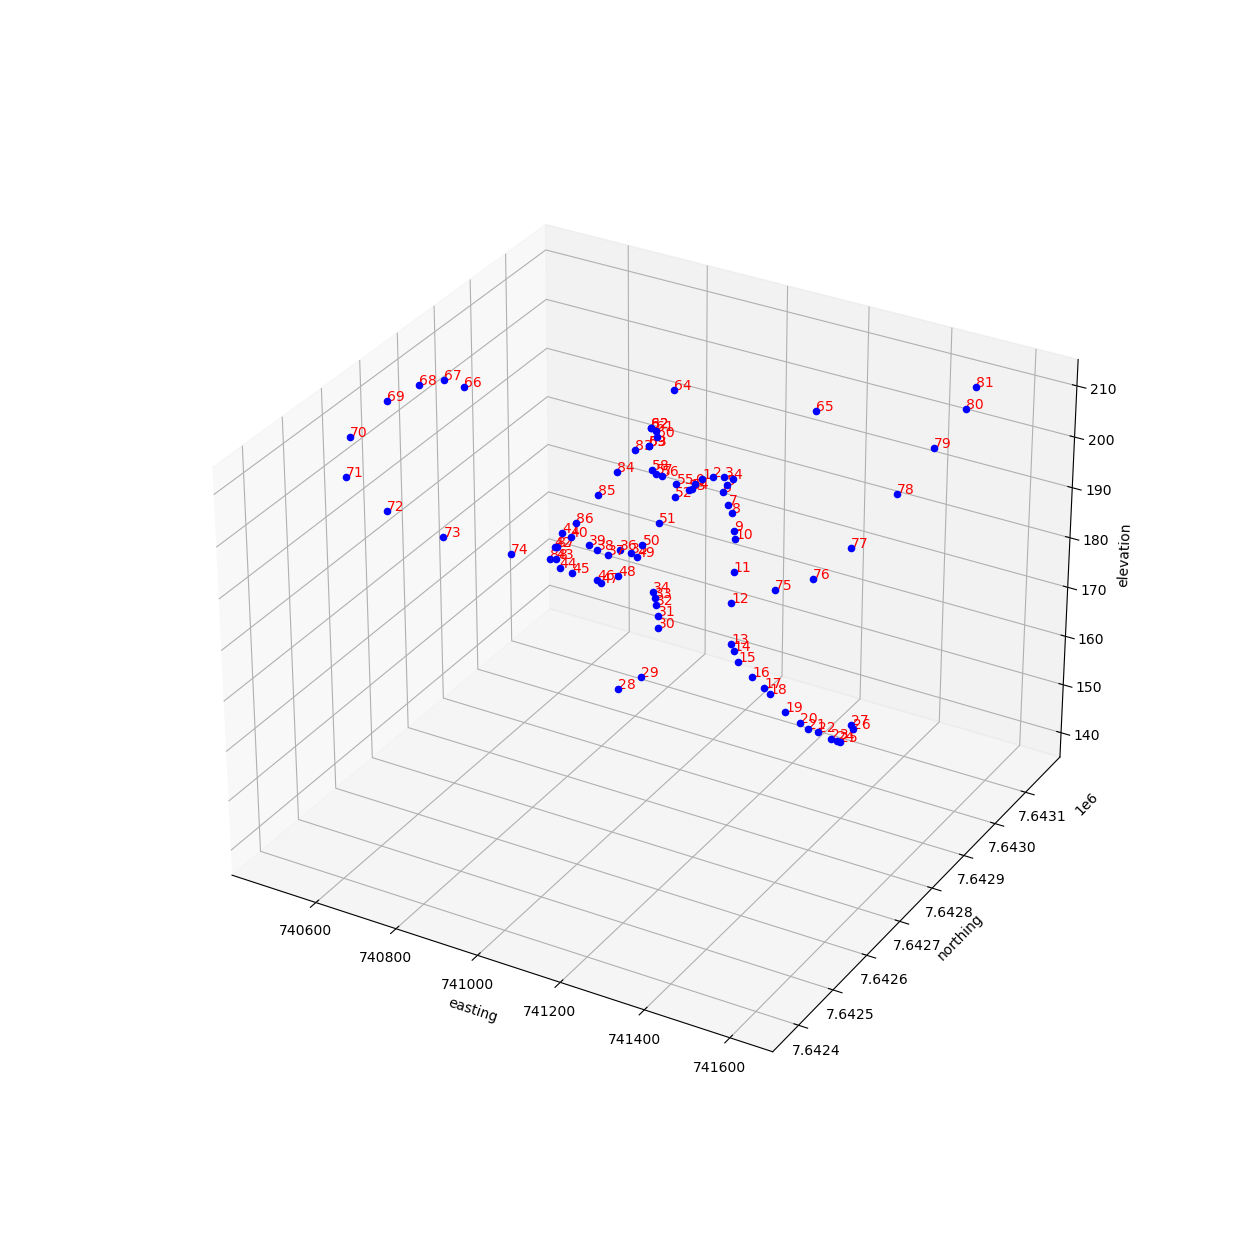

In [5]:
fig = plt.figure()
fig.set_size_inches(12.5, 12.5, forward=True)
ax = fig.add_subplot(projection='3d')
temp, flag = [0,0,0,0], False
pathsExport = []

for i, point in enumerate(plot):
    x = float(point[0])
    y = float(point[1])
    z = float(point[2])
    label = i
    ax.scatter(x, y, z, picker = 'True', color = 'b')
    ax.text(x, y, z, i, color = 'red')

ax.set_xlabel('easting')
ax.set_ylabel('northing')
ax.set_zlabel('elevation')

def onclick(event):
    global temp
    global flag
    global pathsExport
    x, y, z = event.artist._offsets3d
    a = [float(x), float(y), float(z)]
    m = pow(a[0], 2) + pow(a[1], 2) + pow(a[2], 2)
    a.append(nodes.find(root, m))
    ax.set_title(a)
    
    if a != temp and flag == True:
        ax.plot([a[0], temp[0]], [a[1], temp[1]], [a[2], temp[2]], color='black')
        pathsExport.append([temp[3], a[3]])
    else:
        flag = True
        
    temp = a

def keyboardPress(event):
    global temp
    global flag
    global pathsExport
    if event.key == "z":
        ax.lines.pop(-1)
        pathsExport.pop(-1)
        temp, flag = [0,0,0], False
    elif event.key == "c":
        temp, flag = [0,0,0], False
    elif event.key == "enter":
        if path.exists('paths.csv'):
            os.remove('paths.csv')
        with open("paths.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(pathsExport)
    

fig.canvas.callbacks.connect('pick_event', onclick)
fig.canvas.callbacks.connect('key_press_event', keyboardPress)
plt.show()